# read and save datasets

In this notebook, we're going to learn how to load the processed datasets produced by 10x Genomics' [CellRanger](https://support.10xgenomics.com/single-cell-vdj/software/pipelines/latest/what-is-cell-ranger) software and save our results. The [dataset](https://www.10xgenomics.com/resources/datasets/10-k-human-pbm-cs-5-v-2-0-chromium-x-2-standard-6-1-0) we're going to use was downloaded from 10x Genomics. The input sample was **~16,000** cells, with a total of **9,391** cells recovered. The libraries include:

* gene expression (``count``)
* paired BCRs (``vdj-b``)
* paired TCRs (``vdj-t``)
  
The first thing we need to do is import `scab`, which is our Python package for single cell analyses:
  

In [2]:
import scab

`scab` is based in part on [Scanpy](https://scanpy.readthedocs.io/en/stable/), which is built around a very interesting data structure called [AnnData](https://anndata.readthedocs.io/en/stable/generated/anndata.AnnData.html#anndata.AnnData):

<div style="text-align: center;">
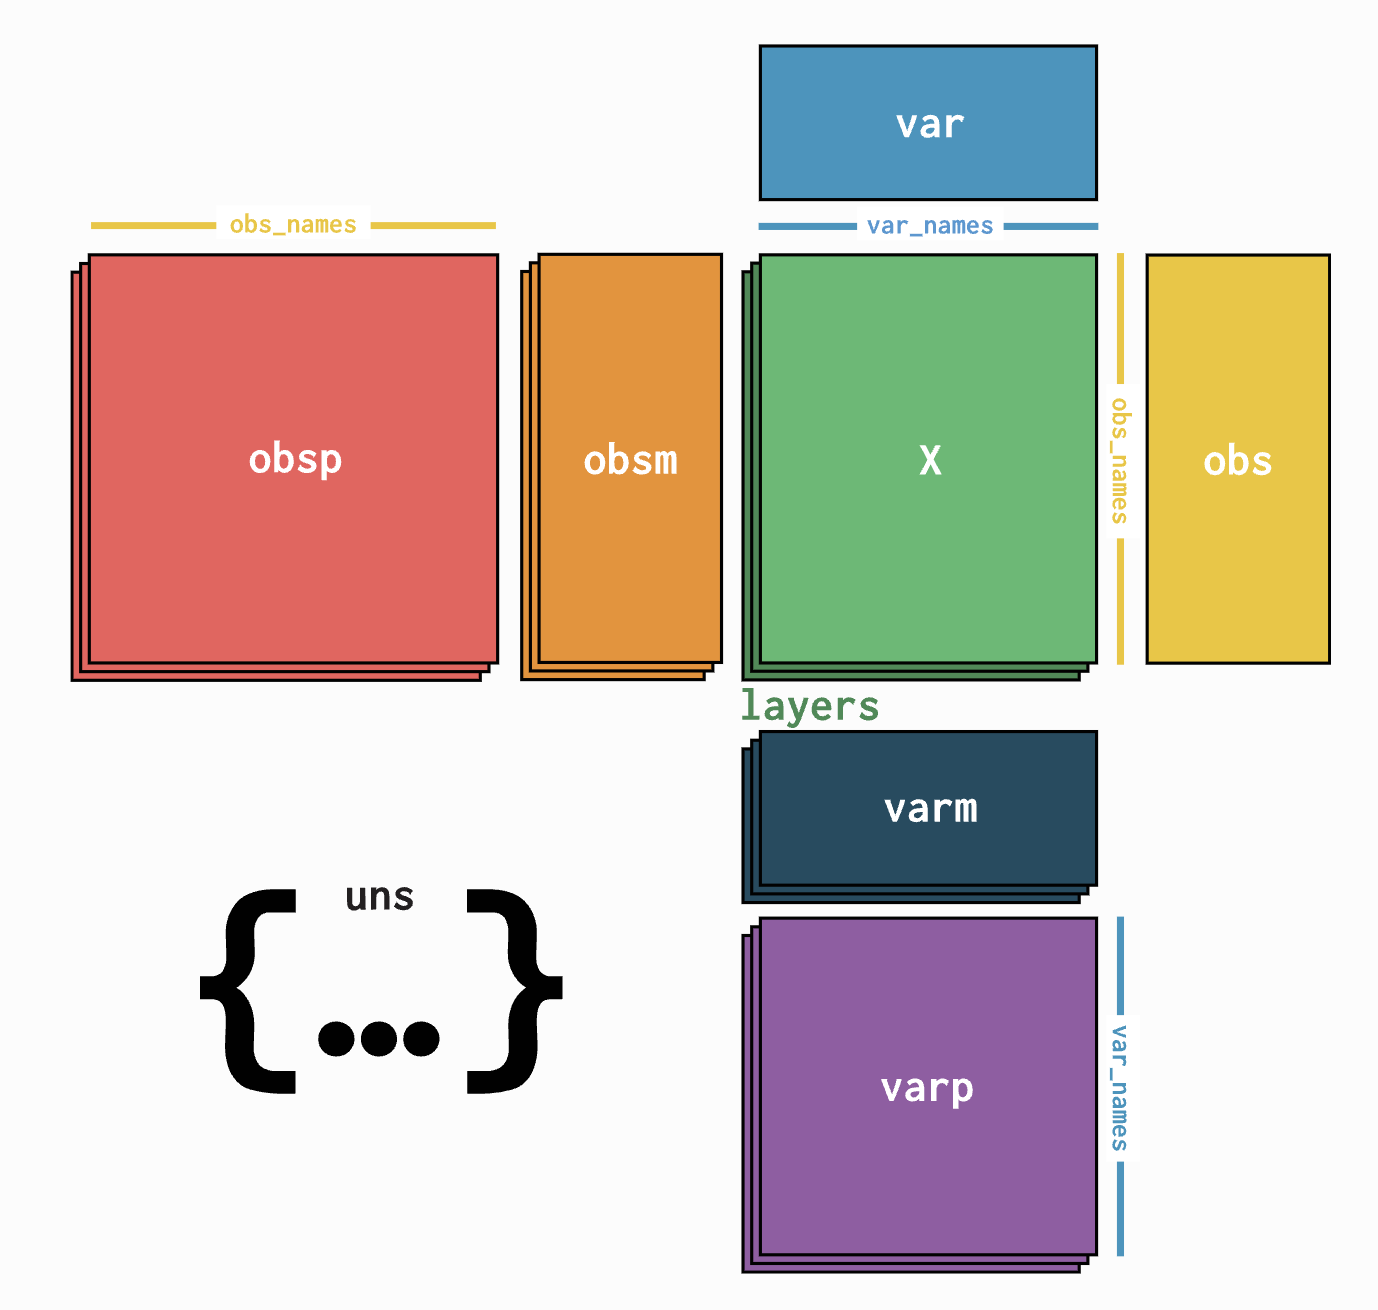
</div>

<br>

There's a lot of information in that image, but we're mainly concerned with three things: `X`, `obs`, and `var`. 

* `X` is where we store gene expression data. Columns correspond to genes, rows are cells, and the values in the matrix are the UMI counts
* `obs` contains cell annotations. For example, this is where we store BCR/TCR sequence information.
* `var` contains gene annotations. For example, certain genes that differ substantially between cells in a particular dataset can be tagged as _highly_variable_ by some of the tools we'll use for analyzing transcirptional profiles.
  
`scab` has a built-in function for loading multiple datasets (gene expression, BCR, and/or TCR) and integrating them into a single `AnnData` object, called `read_10x_mtx()`. Strange name, but we used it to stay consistent with similar functions in `Scanpy` so that users who were familiar with `Scanpy` can transition to `scab` as easily as possible. The goal of `read_10x_mtx()` is to accept CellRanger outputs directly, without the need to modify or pre-process them in any way. We'll provide several arguments:

* `mtx_path`: Path to a folder containing the counts matrix created by CellRanger. Usually named something like `"sample_feature_bc_matrix"`. This argument is required.
* `bcr_file`: Path to a FASTA-formatted file containing BCR contigs generated by CellRanger. Usually named something like `"filtered_contig.fasta"`.
* `bcr_annot`: Path to a CSV-formatted file containing CellRanger-generated annotations for each BCR contig. Note that this is not the `airr_annotations` file (which is TSV-formatted), but is the annotation file containing information like UMI counts, etc. Usually named something like `"filtered_contig_annotations.csvb"`.
* `tcr_file`: Path to a FASTA-formatted file containing TCR contigs.
* `tcr_annot`: Path to the TCR annotations file.

We'll load the data using these files, and save the result to an object we're calling `adata`:


In [3]:
adata = scab.read_10x_mtx(
    mtx_path="./data/10k-PBMCs_from-10x/count/sample_feature_bc_matrix/",
    bcr_file="./data/10k-PBMCs_from-10x/vdj-b/filtered_contig.fasta",
    bcr_annot="./data/10k-PBMCs_from-10x/vdj-b/filtered_contig_annotations.csv",
    tcr_file="./data/10k-PBMCs_from-10x/vdj-t/filtered_contig.fasta",
    tcr_annot="./data/10k-PBMCs_from-10x/vdj-t/filtered_contig_annotations.csv",
)

reading 10x Genomics matrix file...
reading FASTA-formatted BCR data...
annotating BCR sequences with abstar...

Running abstar...
(2/2) ||||||||||||||||||||||||||||||||||||||||||||||||||||  100%

983 sequences contained an identifiable rearrangement
abstar completed in 12.11 seconds

reading FASTA-formatted TCR data...
annotating TCR sequences with abstar...

Running abstar...
(19/19) ||||||||||||||||||||||||||||||||||||||||||||||||||||  100%

9081 sequences contained an identifiable rearrangement
abstar completed in 39.26 seconds



<br>  
  
OK, so a lot of things just happened. First, we read the counts matrix (which contains gene expression information) and create an `AnnData` object. Next, we loaded BCR sequences and annotated the sequences using `abstar`. This produces a large amount of information, comparable to the output produced by IMGT's V/QUEST: germline gene assignment, CDR3 lengths, mutations, etc. The same process was repeated for TCR sequences. Finally, the BCR and TCR data was integrated into the `obs` portion of our `AnnData` obnject. Here's what our fancy new `Anndata` object contains:

In [5]:
adata

AnnData object with n_obs × n_vars = 9391 × 36601
    obs: 'bcr', 'bcr_pairing', 'is_bcr_pair', 'tcr', 'tcr_pairing', 'is_tcr_pair'
    var: 'gene_ids', 'feature_types'

<br>  

Let's walk through that output line-by-line to understand what it means:
  
* `AnnData object with n_obs × n_vars = 9391 × 36601`: Our `AnnData` object contains data for 9,391 observations (cells) and 36,601 variables (genes). When loading data from human samples, we virtually always get 36,601 variables, since that's the number of genes in the default human reference genome used by CellRanger.
* `obs: 'bcr', 'bcr_pairing', 'is_bcr_pair', 'tcr', 'tcr_pairing', 'is_tcr_pair'`: The `obs` portion of our `AnnData` object has a total of 6 columns: three related to BCR data and three related to TCR data. We'll discuss these more in in just a minute.
* `var: 'gene_ids', 'feature_types'`: The `var` portion of our `AnnData` object has two items. Both of these were created by CellRanger, not by `scab`.

<br>  

Great. Now let's take a closer look at the BCR data. We'll start with the `is_bcr_pair` column. This column consists entirely of True/False values, and is `True` if the cell contains at least one BCR heavy chain and at least one BCR light chain. So how many paired BCRs did we recover? We can find that out with the following:

In [8]:
adata.obs.is_bcr_pair.value_counts()

False    8919
True      472
Name: is_bcr_pair, dtype: int64

<br>  

So we have a total of 472 cells with paired BCR sequences. Although that seems low, remember that this dataset is total PBMCs, of which B cells are only ~10%. 
  
Now let's save our `AnnData` object, so that next time we load this data, we don't have to run through the `abstar` annotation steps. For this, we'll use the `save()` function. It takes two arguments: the `AnnData` object we want to save, and the path to an `.h5ad` file. Be a little careful -- if an `.h5ad` already exists at the path you provide, `scab` will overwrite that file with the new data:

In [9]:
scab.save(adata, "./data/10k-PBMCs_from-10x/adatas/read-and-save.h5ad")

<br>  

Nice job! To load a previously-saved `.h5ad` file, you can use the `read()` function. The following will load the file we just saved, and assign it to the `reloaded_adata` variable:

In [10]:
reloaded_adata = scab.read("./data/10k-PBMCs_from-10x/adatas/read-and-save.h5ad")

<br>  

Much faster than loading for the first time, and by introspection we can see that `reloaded_adata` contains the same information as `adata`:

In [12]:
reloaded_adata

AnnData object with n_obs × n_vars = 9391 × 36601
    obs: 'bcr', 'bcr_pairing', 'is_bcr_pair', 'tcr', 'tcr_pairing', 'is_tcr_pair'
    var: 'gene_ids', 'feature_types'

In [13]:
reloaded_adata.obs.is_bcr_pair.value_counts()

False    8919
True      472
Name: is_bcr_pair, dtype: int64